# **Topological Decoupling of Quasi-Periodic Videos**

 **Alpha Recio, Juan Rosete, and Michael Eddy** 


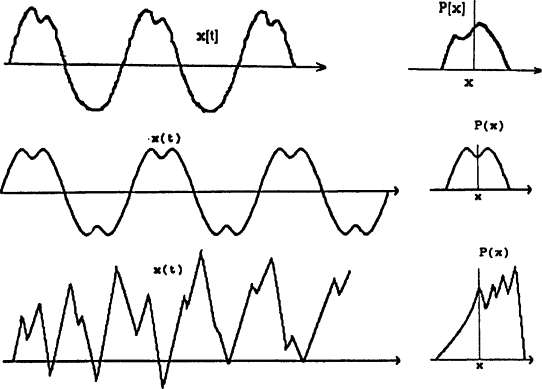

<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>


[<center> <span style = "font-size: 12px;"> Figure: Quasi Periodicity - An Overview</span> <center><br>](https://www.sciencedirect.com/topics/engineering/quasi-periodicity)

    

## **Purpose**<br>

In many areas of science, there exists objects whose motion can be described as quasi-periodic. Examples of such motion include musical compositions, fractal structures, and ocean waves, among others. As such, these objects are characterized by periodic functions with incommensurable frequency. Lying at the intersection of topology and data analysis, our work centers around isolating quasi-periodic movements found in video data. Specifically, the code below presents a chain of algorithms that, when given a video with $N$ independent oscillations, rearranges the frames in $N$ different ways such that for the $n$th video created, the $n$th oscillation will be in motion while the others remain stationary. In this file, we provide a walkthrough of a particular example of our work. 


## **Motivation** <br>
The video below shows two quasi-periodic oscillations against a grey-scale background. We will aim to generate two videos in which one oscillation exhibits motion while the other remains relatively stationary.  

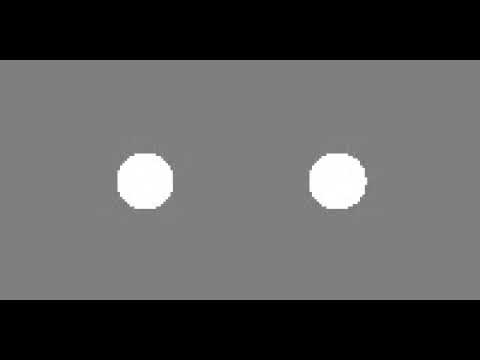

In [4]:

from IPython.display import YouTubeVideo

YouTubeVideo("AD570eD8Z3M", width=600, height=400)

<br/><br/>
## **Reformatting the Data**

To begin, we transform a video into an appropirate format for data analysis using the following process: 
1. Read in a video as collection of frames, where each frame is represented as a vector in the space $R^{(H*W)}$. (The dimensions $H$ and $W$ represent the height and width of all frames respectively.) 
2. Create a dataset matrix $X$ with dimensions $N*P*3$. (Each row $N$ in the matrix corresponds to the vector representation of a single frame while the number of columns $P$ represents the number of pixels per frame. The dimension "$3$" represents the RGB composition of a single pixel.)

A problem that arises at this stage is that since a pixel of a frame is represented as a $1*3$ array, a vector representation of a frame becomes a nested lists with dimensions $(H*W)*3$, an unreadable format for algorithms that will follow. To account for this issue, our process proceeds with the subsequent step. 

3. Flatten the dimensions of each frame by converting it into a single list of dimensions $1*(H*W*3)$, which we denote as $M$. (With the adjusted matrix $X$, the dimensions are now in a readable format for next the next stage of our work involving the sliding-window algorithm.) 

In [ ]:
#Importing Neccessary Functions 
import numpy as np
from PIL import Image
import cv2
import glob
import os
from pathlib import Path


In [ ]:
#Video helper Function (Performs the steps outlined in the process above)
def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    global n_row, n_col
    n_row, n_col, _ = image.shape 
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)
def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

In [ ]:
#Initlizaing Variable Data, which represents the dataset matrix X
data, shape = loadVideo("/Users/slmathuser/Documents/GitHub/TTSA-Project-3/dots_quasi.wmv")
#Note: If one would like to replicate our work, they must provide a video file path that exists in their computer

## **Detecting Quasi(Periodicity)** 



A recurrence detection tool, we apply a sliding-window algorithm on the video matrix $X$ generated by the process above. For runtime purposes, we make window size $= 16$, the embedding dimension $= 3$, and the sample size $= 500$. In practice, one can manipulate these parameters as they so wish. However, they must keep in the mind that this may significantly effect runtime.

The resulting output of this algorithm is a matrix with dimensions $j*k$, commonly referred to as the sliding window **point cloud**. (The dimensions $j$ and $k$ represent the total number of windows and total number of feautures of a window respectively. We note that feautures simply are all rgb values of every pixel within a frame.)  

In [ ]:
#Sliding Window Function (Performs Sliding Window on a given dataset matrix I with parameters dim, Tau, and dt.
#They represent the embedding dimension, time-delay, and the sampling rate respectively.)

from scipy import interpolate
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt


def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

In [ ]:
#Performing Sliding Window Algorithm 
wSize = 16
dim = 3
Tau = wSize/float(dim)
desiredSamples=500
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)
X = getSlidingWindowVideo(data, dim, Tau, dT)

XS = X - np.mean(X, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

#X = X - np.amin(X)
#X = X/np.amax(X)
#X = np.uint8(*255)
frame_data = X[:, 0:data.shape[1]]

print("The sliding-window algorithm produced %d windows, wherein each there" 
      " are %d flattened RGB value elements." % (X.shape[0], X.shape[1]))

## **Principal Component Analysis**

A data analytic technique, principal component analysis (PCA) is a tool used to reduce the dimensionality of a dataset while still preserving the most important information by finding the directions of maximum variance. Given that the generated sliding-window point cloud exists in a dimension unperceivable by the human eye, we can use principal component analysis (PCA) for visualization purposes! (In particular, it is necessary for visualizing the persistent cohomology classes detected by the point cloud, which will be discussed shortly.) 

In [ ]:
#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
%matplotlib inline  

In [ ]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=5) #number of components can be manipulated by user
XS_pca = pca.fit(XS).transform(XS)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window'); #Plot displays the amount of variance captured by the first
#n principal componenets

The figure above displays the amount of variance captured by the first four principal components.   

## **Ripser**

As a python package, **Ripser** provides an interface for computing the persistent co-homology of dense data sets and their persistence diagrams. It takes as input one of two things: a distance matrix of a sliding-window point cloud or a sliding-window point cloud that has had PCA applied to it. For our purposes, we concerned ourselves with the latter.

Lets perform ripser below to identify the cohomology classes detected in the sliding-window point cloud. 

In [ ]:
from ripser import ripser 
from persim import plot_diagrams
from sklearn.decomposition import PCA

# Compute persistence diagrams of the pca vesion of the sliding window point cloud
res = ripser(XS_pca, maxdim=2, n_perm =200, coeff =13, thresh = 0.9)
dgms = res['dgms']
plt.figure(figsize = (3,3)) 
plot_diagrams(dgms)

From the persistence diagram, we are able to make two observations: 
1. Present in the point cloud are two one-dimensional holes, which are represnted by the two orange dots. 
2. Also present is a single two-dimensional hole, represented by the green dot.


Fortunately, these results are what we desire. The reason why stems is as follows: **under appropriate parameters, the sliding-window point cloud of a quasi-periodic signal is dense in an $N$-Torus, which can be thought of as an $N$-dimensional hole.** 

Given the presence of a two-dimensional hole with the potential to represent a torus, $\mathbb{T}^2$, we can conclude that there is a possibility that a quasiperiodic pattern was detected by the point cloud. This observation aligns with our initial expectations, considering the quasiperiodic nature of the video that was first introduced.

## **DREiMAC**

 Put briefly, the **DREiMAC** algorithm "takes as input a point cloud together with a topological feauture (in the form of a persistent cohomology class), and returns a map from the point cloud to a well-understood space (a circle, a product of circles, a projective space, or a lens space), which preserves the given topological feauture in a precise sense" (Perea, Soccola, and Tralie, 2020)

Given that we primarily provide DREiMAC with topological feautures in the form of one-dimensional holes, the basis for this algorithm is grounded by the following **characterization theorem** of the first cohomology group $H^1$: let $X$ be a data set, $B$ a rips complex, $h^1$ a cohomology class, and $S^1$ the unit circle. Assigning a defined function $f:$ $B$ $\rightarrow$ $S^1$ to $h^1$, we form a mapping determined by $h^1$ of the Rips complex to the unit circle represented by the interval $[0,2\pi]$. 

Performing this procedure for all $h^1$ $\epsilon$ $H^1$, we form a homeomorphism between the first cohomology group of the Rips Complex and the set of continuous maps $f$ from the rips complex to the unit circle. In notation form, we have

**<center> $H^1$$(B,Z)$ $\cong$ $[B,S^1]$<center>**

With this theorem in mind, we proceed with describing the two ways in which DREiMAC was most useful to our work. 

### **Point Cloud Visualization**

In [ ]:
#topological data analysis
from persim import plot_diagrams
from dreimac import CircularCoords 
from dreimac import CircleMapUtils as CMU


In [ ]:
n_lands = 450 #Here we have chosen 450, however, one can choose any value so long as it is 
#less than the sample size originally chosen for the sliding-window algorithm
cc = CircularCoords(XS, n_landmarks=n_lands)

In [1]:
# Get the circular coordinates at birth, and for the 2 cocycles with highest persistence
coho_classes=[]

for i in range(2): 
    coho_classes.append(i)

circular_coords = []

for i in coho_classes:
    #perc: specifies the time in filtration to construct the coordinates 
    #cocyle_index: Picks a persistent homology class when the classes are ordered with respect to persistence
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)

NameError: name 'cc' is not defined

In [ ]:
# Plot data with N circular coordinates

fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=XS_pca[:,0], y=XS_pca[:,1], z=XS_pca[:,2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()

The point clouds above correspond to the first and second cohomology classes with the highest persistence. Specifically, their coloring scheme results from the map $f$ of the Rips complex to the space $S^1$ as described by the characterization theorem. The color of a particular point corresponds to its location on the interval $[0,2\pi]$ under this mapping.     

Moving forward, it is important note the following: **each window has a corresponding point on the tori.** That is, the number of points used to generate the tori above exactly matches the number of windows produced by the sliding-window algorithm.    

### **Sorting By Way of Circular Coordinates**

For each point of the tori (i.e. a window), the DREiMAC algorithm assigns a set of values known as circular coordinates that exists on the interval [0,2&pi;]. This range results from the fact that such coordinates are commonly used to represent points on a circle or a sphere. 

The relevance to our work stems from the following fact: **a circular coordinate system is disinct in that it utilizes angles rather than traditional cartesian coordinates to describe the geometric position of a point relative to an origin.** 

In [ ]:
#Gathering Angle Values Corresponding to Cohomology Classes
thetavals=[]
for i in range(len(circular_coords)):
    list=[]
    for j in range(len(circular_coords[i])): 
        theta=circular_coords[i][j]
        list.append(theta)
    thetavals.append(list)
    
thetavals=np.array(thetavals)

Having gathered the coordinates of each cohomology class, we highlight an important idea: **the disentangling of oscillators through frame rearrangment aligns with the traversal of their tori in different ways**. By resequencing the points of the torus based on their sorted circular coordinates, we have the ability the change the arrangement of the sliding window algorithm's windows and, as a result, alter the order of video frames in our analysis. The natural question that arises is how exactly do we sort generated circular coordinates. In the lines that follow, we answer this question and provide the code that achieves this.       

We begin our sorting approach as follows: 

In [ ]:
#Initialize an empty list wherein the indices of to be ordered theta values are stored
sortedindexes=[] 
#Iterate over the nested lists contained in thetavals and **perform the np.argsort command** on them 
#(provides the indices of the theta values arranged from smallest to largest for each cohomology class)
for j in range(len(thetavals)):
    sortedidx=np.argsort(thetavals[j])
    sortedindexes.append(sortedidx)

## **Averaging Overlapping Windows** 


Depending on the parameters set when performing the sliding-window algorithm, one may have to resolve the issue posed by overlapping windows when creating a video. In particular, one must find a way to detect and compute the average of overlapping elements.  

To achieve this, our algorithm is guided by the following process:

1. We must create a new array, $Y$, of a proper format to create a video from it. However, its dimensions must match that of the original matrix, $X$. Therefore, we begin by iterating over the indices of $X$ to replicate its number of rows for $Y$.
2. Within this iteration loop, initialize a new variable $X\_sort$ which represents a sorted sliding window point cloud. The ordering of the windows are determined by the sorted indices of the ith cohomology class
3. In the same loop, iterate over every window of $X\_sort$ based on angles and check for overlaps. 
4. If there is no overlap, store the windows in a new sublist. If there is overlap, store the indices of overlapping windows in a separate sublist. 
5. After the loops finished, find the maximum value of overlapping indices to determine the last overlapped element for the next step. 
6. Iterate over the windows of overlapping indices and and calculate the averages of overlapping elements until you reached the index with maximum value. 
7. Store the averaged values in the sublists with non-overlapping windows to create a fledgling video matrix. 
8. From this matrix, take the first $60,000$ elements from each row and store them in chunks of size $3$ to replicate the RGB value composition of each pixel. 
9. Reshape the matrix, $Y$, to match the configurations and resolution of original video.
10. Write two new videos displaying the relatively stationary movement of each oscillator independently.

Shown below is the implemented code that performs this process.

In [ ]:
#Averaging Overlapping Windows (N Case)

for i in range(2):
    first_elements=[]
    overlap_indices=[]
    X_sort=X[sortedindexes[i]]
    for j in range(len(X)):
        sublist=[]
        overlap_flag=False
        for k in range(len(X_sort[j])): 
            sublist.append(X_sort[j][k])
            if not overlap_flag:
                if sublist.count(X_sort[i][j]) > 1:
                    overlap_indices.append(j)
                    overlap_flag = True
        first_elements.append(sublist)
    # Find the index where the overlapping elements end
    overlap_end = max(overlap_indices)

    # Calculate the average of the overlapping elements
    overlap_avg = np.mean([sublist[:overlap_end] for sublist in first_elements], axis=0)

    # Iterate over each sublist and replace the overlapping elements with the average
    for sublist in first_elements:
        sublist[:overlap_end] = overlap_avg

    # Create fl as a list with each row containing 20,000 sub-sublists of size 3
    fl = []
    for sublist in first_elements:
        sublist_chunks = [sublist[i:i+3] for i in range(0, len(sublist), 3)]
        flattened_chunks = [item for sublist in sublist_chunks for item in sublist]  # Flatten the sublist chunks
        fl.extend(flattened_chunks[:20000*3])  # Extend fl with flattened chunks

    # Reshape fl to have the desired shape (*depends on desired samples*, 20000, 3)
    fl_reshaped = np.array(fl).reshape((X.shape[0], (n_row*n_col), 3))

    writeVideo("pilot_%i.mp4" % (i), fl_reshaped, 5, (n_row,n_col))

## **Final Results**

In [5]:
YouTubeVideo("kkNruwyx2uc", width=600, height=400)

In [6]:
YouTubeVideo("ky15nVeoOVc", width=600, height=400)

The videos above display our attempt to generate two videos in which one oscillator is moving while the other remains relatively stationary. 

## **Next Steps**

As a walkthrough, we hope that this is able to provide the user with a solid understanding of our work. However, there is much progress to be made. Specificially, we challenge the user to explore the following: 

1. Explore different ways of traversing the torus and seeing how this effects oscillator movement.
2. Discover a way to preserve the color scheme of the original video and its resolution.
3. Implement code modifications that will allow for a faster runtime.
4. For the extra curious, explore the application of our work to quasiperiodic solutions to the Kuramoto Sivashinsky equation

## **Useful References**<br> 

[(Quasi)Periodicity Quantification in Video Data, Using Topology](https://arxiv.org/pdf/1704.08382.pdf) by Christopher J. Tralie and Jose A. Perea 

[DREiMac- Dimensionality Reduction with Eilenberg-MacLane Coordinates](https://scikit-tda.org/DREiMac/index.html) - Provides theoretical background of the DREiMac algorithm and several examples of its application.  

[GitHub Repository](github.com/areciovaleri/TTSA-Project-3)- Repository that contains all code developed for our work

[Kuramoto Sivashinsky Background](johncarlosbaez.wordpress.com/2021/10/17/conjectures-on-the-kuramoto-sevashinsky-equation/) - Article written by John Baez that provides background to the Kuramoto-Sivashinsky equation 

[Kuramamoto Sivashinsky Equation - Transition to Chaos (Richters Finger)](www.youtube.com/watch?v=YKi_PRMl0cE) -  Visual that displays the transition of a solution to the Kuramoto-Sivashinsky equation under various changing parameters 